<a href="https://colab.research.google.com/github/R2D2oid/Adhoc-Visualizations/blob/main/Plot_pre_trained_OOD_vs_ID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 86 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


## Load previously generated MSP scores from drive

- datasets:
  - in-distribution: Kinetics400 test set
  - out-of-distribution: Ego4D
- T={1,10,100,1000}
- model=```{'slowfast_4x16_resnet50', 'c3d', 'i3d_inceptionv3', 'r2plus1d_resnet50'}```

In [44]:
from google.colab import drive
drive.mount('/content/drive')

import pickle as pkl
from mxnet import nd
import numpy as np
import os 

def get_msps(path_):   
  out = {}
  for f in os.listdir(path_):
    out[f] = pkl.load(open(f'{path_}/{f}', 'rb'))

  return out

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
rootdir = 'drive/My Drive/Video_OOD'
path_ = f'{rootdir}/output/MSPs'
output = get_msps(path_)

In [45]:
def count_ge(msp, delta):
    '''
    counts greater than equal
    '''
    count = 0
    for i in msp:
      if i>=delta:
        count+=1
    return count

def fpr95(msp_id,msp_od):
  if len(msp_id)!=len(msp_od):
    print('OD and ID sample count mismatch!')
    raise Exception

  total = len(msp_id)
  delta95 = np.percentile(msp_id, 5)
  tp = count_ge(msp_id, delta95)
  fn = total-tp
  fp = count_ge(msp_od, delta95)
  tn = total-fp
  fpr95 = fp/(fp+tn)
  return fpr95

def auroc(msp_id,msp_od):
  if len(msp_id)!=len(msp_od):
    print('OD and ID sample count mismatch!')
    raise Exception

  total = len(msp_id)
  min_ = min(msp_id.min(),msp_od.min())
  max_ = max(msp_id.max(),msp_od.max())
  print(min_,max_)
  step_ = (max_-min_)/1000

  deltas = np.arange(min_,max_,step_)
  rs = []
  ps = []
  fprs = []
  for delta in deltas:
    try:
      tp = count_ge(msp_id, delta)
      fn = total-tp
      fp = count_ge(msp_od, delta)
      tn = total-fp

      precision = tp/(tp+fp)
      recall = tp/(tp+fn)
      fpr = fp/(fp+tn)

      rs.append(recall)
      ps.append(precision)
      fprs.append(fpr)
    except Exception as e:
      print(e)
      print(tp, fn, fp, tn)
      print(msp_id)
      print()
      print(msp_od)
  return (np.array(ps), np.array(rs), np.array(fprs))

def plot_AUROC_by_t(modelnames, ts):
  '''
  Inputs: 
    modelnames
    temperature values
    ** assumes MSP experiments are previously loaded into a dict called output
  Output: 
    plots AUROC curves by temperature
  '''
  from matplotlib import pyplot as plt
  for m in modelnames:
    for t in ts:
      print(f'processing t={t}')

      # id msps
      msp_id = output[f'MSPs_T{str(t)}_kinetics400_{m}.pkl']
      msp_id = np.array(msp_id[:900])

      # od msps
      msp_od = output[f'MSPs_T{str(t)}_ego4d_{m}.pkl']
      msp_od = np.array(msp_od[:900])

      fpr95_ = round(fpr95(msp_id,msp_od),2)
      (p,r,fpr) = auroc(msp_id,msp_od)
      plt.plot(fpr, r, label = f't={t} -- fpr95={fpr95_}')

      plt.legend()
      plt.title(f'TPR vs. FPR ({m})')
      plt.xlabel('FPR')
      plt.ylabel('TPR')
      
    plt.show()


def plot_MSPs_hist(modelnames, ts):
  '''
  Inputs: 
    modelnames
    temperature values
    ** assumes MSP experiments are previously loaded into a dict called output
  Output: 
    Plots MSP Histograms for separately each temperature
  '''
  from matplotlib import pyplot as plt

  for m in modelnames:
    for t in ts:
      # id msps
      msp_id = output[f'MSPs_T{str(t)}_kinetics400_{m}.pkl']
      msp_id = np.array(msp_id[:900])

      # od msps
      msp_od = output[f'MSPs_T{str(t)}_ego4d_{m}.pkl']
      msp_od = np.array(msp_od[:900])

      # get histogram of softmax scores
      hist_k400 = plt.hist(msp_id, bins=100)
      hist_ego4d = plt.hist(msp_od, bins=100)
      plt.clf()
      plt.plot(hist_k400[0]/hist_k400[0].sum(), c='b', label='ID: Kinetics')
      plt.plot(hist_ego4d[0]/hist_ego4d[0].sum(), c='r', label='OOD: Ego4D')

      plt.legend()
      plt.title(f'MSP distributions (T={t})\n{m}')
      plt.xlabel('Maximum Sofmaxt Probabities')
      plt.ylabel('Percentage of Videos')
      plt.show()


def plot_AUROC_by_models(modelnames, t):
  '''
  For a given temperature t plots AUROC of several models

  Inputs: 
    modelnames
    temperature values
    ** assumes MSP experiments are previously loaded into a dict called output
  Output: 
    Plots AUROC of multiple models
  '''
  for m in modelnames:
    # id msps
    msp_id = output[f'MSPs_T{str(t)}_kinetics400_{m}.pkl']
    msp_id = np.array(msp_id[:900])

    # od msps
    msp_od = output[f'MSPs_T{str(t)}_ego4d_{m}.pkl']
    msp_od = np.array(msp_od[:900])

    fpr95_ = round(fpr95(msp_id,msp_od),2)
    (p,r,fpr) = auroc(msp_id,msp_od)
    plt.plot(fpr, r, label = f'{m} \n FPR95={fpr95_}')

    plt.legend()
    plt.title(f'TPR vs. FPR (T={t})')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
      
  plt.show()

# Plot AUROC by Temperature

processing t=1...
0.003803544 1.0
processing t=10...
0.002609624 0.9181021
processing t=100...
0.0025107758 0.006225412
processing t=1000...
0.0025010754 0.002740245
processing t=10000...
0.0025001075 0.0025230565


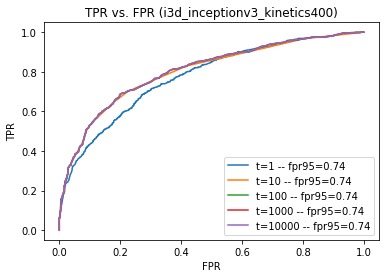

processing t=1...
0.009879229 0.9751031
processing t=10...
0.0028985436 0.012935839
processing t=100...
0.0025375152 0.0029639406
processing t=1000...
0.0025037292 0.0025430513
processing t=10000...
0.0025003727 0.0025042736


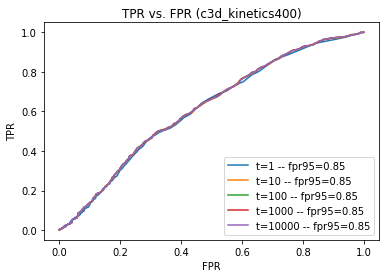

In [30]:
modelnames = ['i3d_inceptionv3_kinetics400', 'c3d_kinetics400'] # modelnames
ts = [1,10,100,1000,10000] # temperature values
plot_MSPs_by_t(modelnames, ts)

In [ ]:
# a large T makes the softmax values more smooth. It has a more substantial smoothing effect on the more peaky distribition (In-distribution)

# Plot MSP Histogarm by Temperature

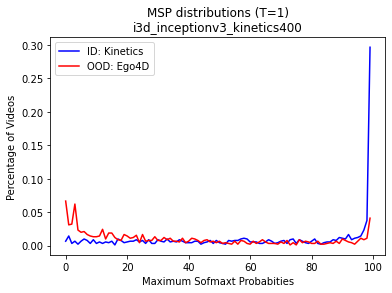

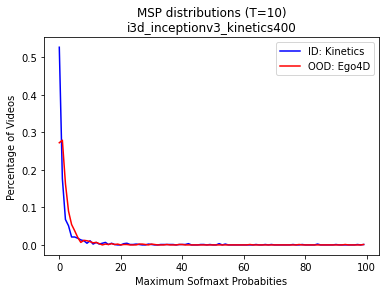

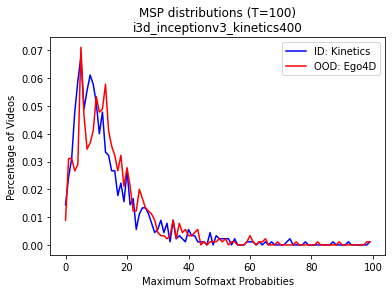

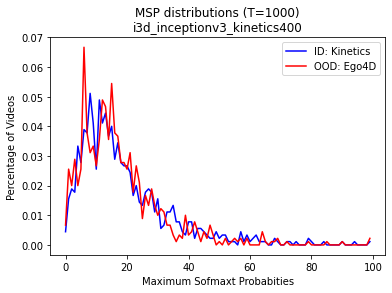

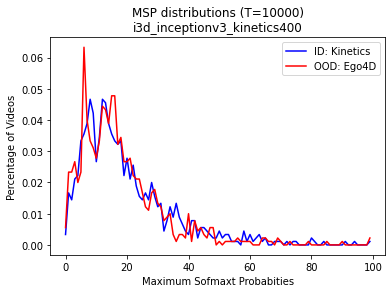

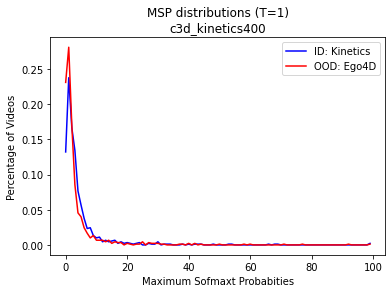

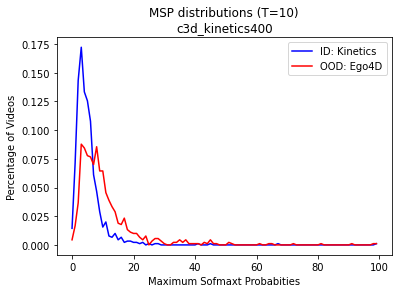

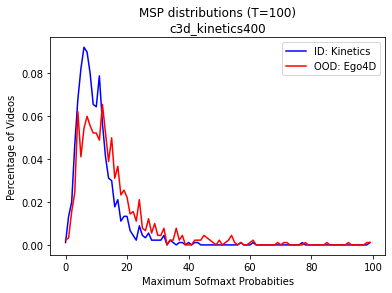

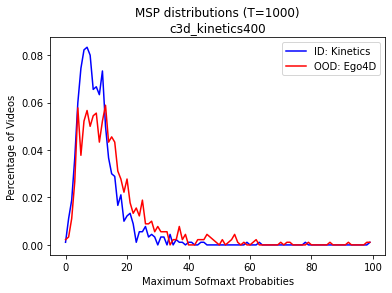

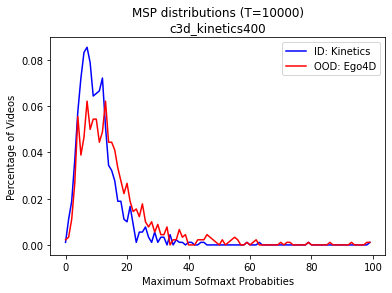

In [39]:
modelnames = ['i3d_inceptionv3_kinetics400', 'c3d_kinetics400'] # modelnames
ts = [1,10,100,1000,10000] # temperature values
plot_MSPs_hist(modelnames, ts)

0.0025673243 0.005035202
0.0025375152 0.0029639406
0.0025751784 0.0033566575
0.0025107758 0.006225412


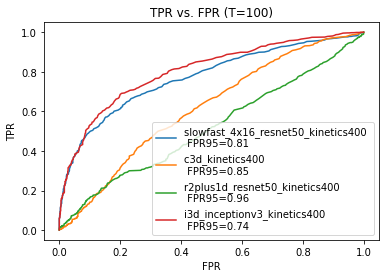

In [47]:
modelnames = ['slowfast_4x16_resnet50_kinetics400', 'c3d_kinetics400', 'r2plus1d_resnet50_kinetics400', 'i3d_inceptionv3_kinetics400']
t = 100 # temperature values
plot_AUROC_by_models(modelnames, t)